# Diamond Analysis and Classification Model
 
This notebook analyzes diamond characteristics and builds a classification model to predict diamond properties based on images.


## Data Loading and Preprocessing

First, we'll load the diamond dataset and perform initial preprocessing steps.

In [4]:
# Diamond Analysis Model: Image-Based Diamond Characteristic Prediction
# ====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
import re
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Using device: cpu
PyTorch version: 2.2.2
Torchvision version: 0.17.2


## Exploratory Data Analysis

Let's explore the dataset to understand the distribution of diamond characteristics.

In [5]:
# Load the diamond details CSV file
df = pd.read_csv('diamond_scraped/diamond_details.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
display(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset shape: (65693, 18)

First few rows of the dataset:


,title,shape,carat,color,clarity,cut,polish,symmetry,fluorescence,dimensions,table,depth,girdle,culet,certificate,stock_number,path_to_img,path_to_gia
0,0.30 ct K SI1 Round Shape Natural Diamond,Round,0.30,K,SI1,Very good,Excellent,Very good,NaN,4.24 - 4.18 x 2.6,62%,61.7%,Thick,NaN,GIA,AN1E-100757812225767,diamond_scraped/diamond_images/Round/an1e-1007...,https://photo.diamondasset.in:8080/Picture/549...
1,0.31 ct L VS2 Round Shape Natural Diamond,Round,0.31,L,VS2,Excellent,Excellent,Excellent,Faint,4.32 - 4.29 x 2.67,57%,62%,Medium - Slightly Thick,NaN,GIA,AN1E-100760588693681,diamond_scraped/diamond_images/Round/an1e-1007...,https://photo.diamondasset.in:8080/Picture/338...
2,0.30 ct K VS2 Round Shape Natural Diamond,Round,0.30,K,VS2,Excellent,Excellent,Excellent,Medium,4.28 - 4.26 x 2.68,57%,62.8%,Medium - Slightly Thick,NaN,GIA,AN1E-100760133040573,diamond_scraped/diamond_images/Round/an1e-1007...,https://photo.diamondasset.in:8080/Picture/228...
3,0.34 ct J SI2 Round Shape Natural Diamond,Round,0.34,J,SI2,Excellent,Excellent,Very good,Faint,4.49 - 4.46 x 2.76,60%,61.8%,Medium,NaN,GIA,AN1E-100748517671222,diamond_scraped/diamond_images/Round/an1e-1007...,https://photo.diamondasset.in:8080/Picture/646...
4,0.18 ct H VVS2 Round Shape Natural Diamond,Round,0.18,H,VVS2,Excellent,Excellent,Excellent,Faint,3.61 - 3.63 x 2.25,58%,62.2%,F,NaN,GIA,EDLI-LD24042949194,NaN,https://certifiedstone.info/certi/LD24042949.pdf



Missing values in each column:
title               0
shape               0
carat               0
color               0
clarity             0
cut                 0
polish              0
symmetry            0
fluorescence    47701
dimensions          0
table               0
depth               0
girdle             54
culet           64834
certificate         0
stock_number        0
path_to_img      4095
path_to_gia      8421
dtype: int64


## Image Dataset Creation

We'll create a custom dataset class to handle diamond images and their labels.

In [9]:
# Check if image paths exist and filter out rows with missing images
df['image_exists'] = df['path_to_img'].apply(lambda x: os.path.exists(x) if isinstance(x, str) and len(x) > 0 else False)
df_with_images = df[df['image_exists'] == True].copy()
print(f"\nRows with valid images: {df_with_images.shape[0]} out of {df.shape[0]} total rows")

# Drop unnecessary columns
df_with_images.drop(['image_exists', 'title', 'stock_number', 'path_to_gia'], axis=1, inplace=True)

# Convert numeric columns to appropriate types
numeric_cols = ['carat', 'table', 'depth']
for col in numeric_cols:
    if col in ['table', 'depth']:
        # For columns that might have % symbols
        df_with_images[col] = df_with_images[col].astype(str).str.replace('%', '').astype(float)
    else:
        # For columns that are already numeric
        df_with_images[col] = df_with_images[col].astype(float)

# Extract dimensions as separate features
def extract_dimensions(dim_str):
    if pd.isna(dim_str) or not isinstance(dim_str, str):
        return pd.Series([np.nan, np.nan, np.nan], index=['width', 'length', 'height'])
    
    # Try to extract dimensions using regex
    pattern = r'(\d+\.\d+)\s*-\s*(\d+\.\d+)\s*x\s*(\d+\.\d+)'
    match = re.search(pattern, dim_str)
    
    if match:
        return pd.Series([float(match.group(1)), float(match.group(2)), float(match.group(3))], 
                         index=['width', 'length', 'height'])
    else:
        return pd.Series([np.nan, np.nan, np.nan], index=['width', 'length', 'height'])

# Extract dimensions
dimensions_df = df_with_images['dimensions'].apply(extract_dimensions)
df_with_images = pd.concat([df_with_images, dimensions_df], axis=1)

# Display the cleaned dataset
print("\nCleaned dataset:")
display(df_with_images.head())


Rows with valid images: 61598 out of 65693 total rows

Cleaned dataset:


,shape,carat,color,clarity,cut,polish,symmetry,fluorescence,dimensions,table,depth,girdle,culet,certificate,path_to_img,width,length,height
0,Round,0.30,K,SI1,Very good,Excellent,Very good,NaN,4.24 - 4.18 x 2.6,62.0,61.7,Thick,NaN,GIA,diamond_scraped/diamond_images/Round/an1e-1007...,4.24,4.18,2.60
1,Round,0.31,L,VS2,Excellent,Excellent,Excellent,Faint,4.32 - 4.29 x 2.67,57.0,62.0,Medium - Slightly Thick,NaN,GIA,diamond_scraped/diamond_images/Round/an1e-1007...,4.32,4.29,2.67
2,Round,0.30,K,VS2,Excellent,Excellent,Excellent,Medium,4.28 - 4.26 x 2.68,57.0,62.8,Medium - Slightly Thick,NaN,GIA,diamond_scraped/diamond_images/Round/an1e-1007...,4.28,4.26,2.68
3,Round,0.34,J,SI2,Excellent,Excellent,Very good,Faint,4.49 - 4.46 x 2.76,60.0,61.8,Medium,NaN,GIA,diamond_scraped/diamond_images/Round/an1e-1007...,4.49,4.46,2.76
5,Round,0.31,K,VS1,Excellent,Excellent,Excellent,Strong,4.32 - 4.29 x 2.71,56.0,62.9,Medium - Slightly Thick,NaN,GIA,diamond_scraped/diamond_images/Round/an1e-1007...,4.32,4.29,2.71


## Exploratory Data Analysis

Let's explore our data to better understand the distribution of diamond characteristics.

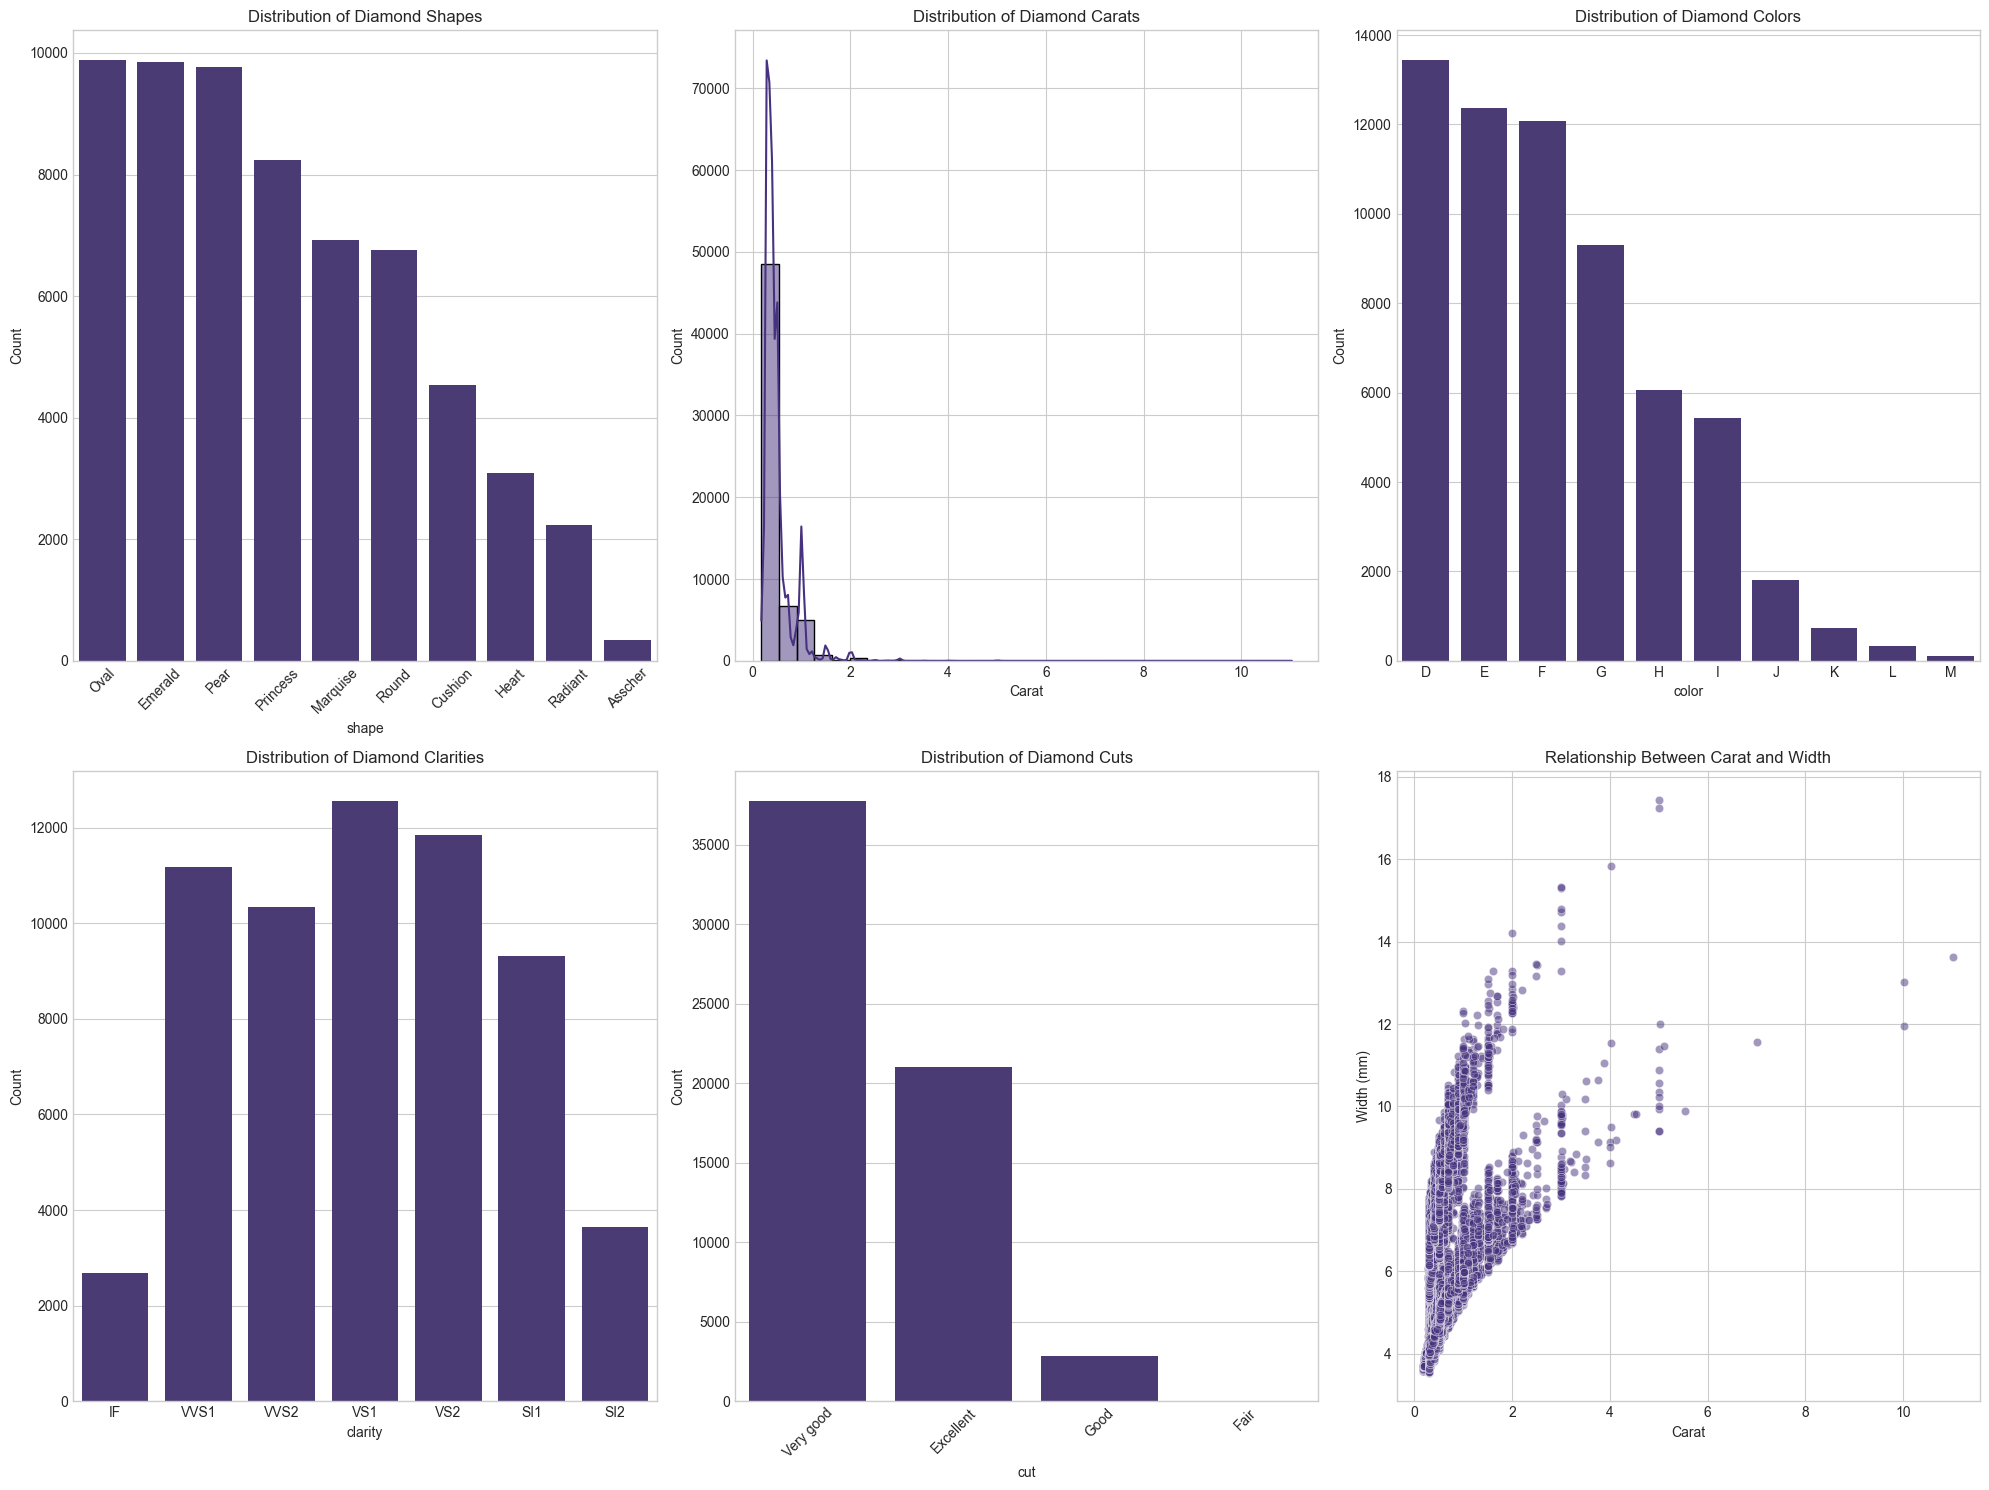

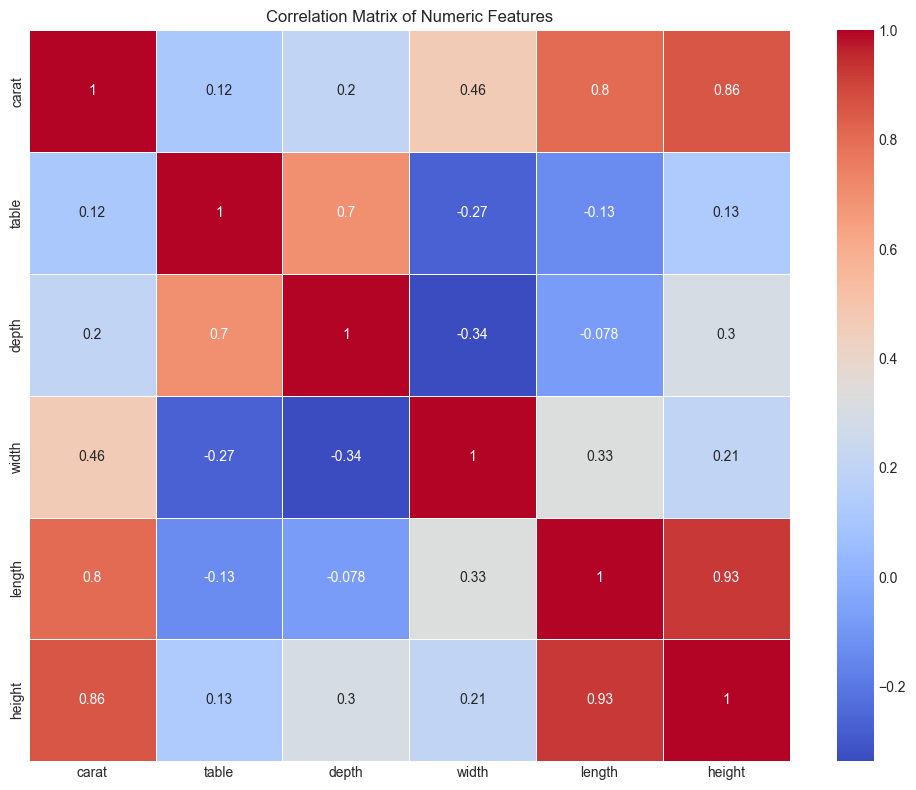

In [11]:
# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure for the plots
plt.figure(figsize=(20, 15))

# 1. Distribution of diamond shapes
plt.subplot(2, 3, 1)
shape_counts = df_with_images['shape'].value_counts()
sns.barplot(x=shape_counts.index, y=shape_counts.values)
plt.title('Distribution of Diamond Shapes')
plt.xticks(rotation=45)
plt.ylabel('Count')

# 2. Distribution of diamond carats
plt.subplot(2, 3, 2)
sns.histplot(df_with_images['carat'], bins=30, kde=True)
plt.title('Distribution of Diamond Carats')
plt.xlabel('Carat')
plt.ylabel('Count')

# 3. Distribution of diamond colors
plt.subplot(2, 3, 3)
color_counts = df_with_images['color'].value_counts().sort_index()
sns.barplot(x=color_counts.index, y=color_counts.values)
plt.title('Distribution of Diamond Colors')
plt.ylabel('Count')

# 4. Distribution of diamond clarities
plt.subplot(2, 3, 4)
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2']
clarity_counts = df_with_images['clarity'].value_counts()
clarity_counts = clarity_counts.reindex(clarity_order) if all(c in clarity_counts.index for c in clarity_order) else clarity_counts
sns.barplot(x=clarity_counts.index, y=clarity_counts.values)
plt.title('Distribution of Diamond Clarities')
plt.ylabel('Count')

# 5. Distribution of diamond cuts
plt.subplot(2, 3, 5)
cut_counts = df_with_images['cut'].value_counts()
sns.barplot(x=cut_counts.index, y=cut_counts.values)
plt.title('Distribution of Diamond Cuts')
plt.xticks(rotation=45)
plt.ylabel('Count')

# 6. Relationship between carat and dimensions
plt.subplot(2, 3, 6)
sns.scatterplot(data=df_with_images, x='carat', y='width', alpha=0.5)
plt.title('Relationship Between Carat and Width')
plt.xlabel('Carat')
plt.ylabel('Width (mm)')

plt.tight_layout()
plt.show()

# Correlation matrix for numeric features
numeric_df = df_with_images[['carat', 'table', 'depth', 'width', 'length', 'height']].copy()
plt.figure(figsize=(10, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## Model Architecture

Define a CNN model for diamond classification based on ResNet50.

In [ ]:
# Custom Dataset class for diamond images
class DiamondDataset(Dataset):
    def __init__(self, dataframe, img_dir, target_col, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.target_col = target_col
        self.transform = transform
        
        # Encode target labels
        self.label_encoder = LabelEncoder()
        self.dataframe['encoded_target'] = self.label_encoder.fit_transform(self.dataframe[target_col])
        self.classes = self.label_encoder.classes_
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path_to_img']
        
        try:
            # Load image
            image = Image.open(img_path).convert('RGB')
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
                
            # Get label
            label = self.dataframe.iloc[idx]['encoded_target']
            
            return image, label
        
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder image and label in case of error
            placeholder = torch.zeros((3, 224, 224))
            return placeholder, 0

# Define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define a CNN model for diamond classification
class DiamondCNN(nn.Module):
    def __init__(self, num_classes, feature_extract=False):
        super(DiamondCNN, self).__init__()
        
        # Load a pre-trained ResNet model
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Freeze parameters if feature extracting
        if feature_extract:
            for param in self.model.parameters():
                param.requires_grad = False
        
        # Modify the final fully connected layer for our number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

## Model Training

Initialize and train the diamond classification model.

In [ ]:
# Function to train the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, scheduler=None):
    since = time.time()
    
    # Initialize variables to track best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Lists to track metrics
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass (track history if only in train)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if scheduler is not None and phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Track history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                
                # Deep copy the model if it's the best so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

# Let's train a model for diamond shape classification
target_column = 'shape'  # We'll start with shape classification

# Split the data into train and validation sets
train_df, val_df = train_test_split(df_with_images, test_size=0.2, random_state=42, stratify=df_with_images[target_column])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create datasets
train_dataset = DiamondDataset(train_df, '', target_column, transform=data_transforms['train'])
val_dataset = DiamondDataset(val_df, '', target_column, transform=data_transforms['val'])

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Initialize the model
num_classes = len(train_dataset.classes)
model = DiamondCNN(num_classes=num_classes, feature_extract=True)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
import time
import copy

model, history = train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    num_epochs=20, 
    scheduler=scheduler
)

# Save the model
torch.save(model.state_dict(), f'diamond_{target_column}_classifier.pth')

## Model Evaluation

Evaluate the model on the validation set and generate performance metrics.

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Function to evaluate the model on the validation set
def evaluate_model(model, dataloader, classes):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, all_preds, all_labels

# Evaluate the model
accuracy, predictions, true_labels = evaluate_model(model, val_dataloader, train_dataset.classes)